# Using K-Means to find the perfect Scotch Whisky!

Uh oh, my favorite bottle of Ardbeg is empty!  How can I find a replacement?

Single malt scotch is a drink that has very specifics tastes and flavors per distillery.   What I'll attempt to do here is use a dataset where the scotch from 84 distilleries was classified by 12 taste components (Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral) to find groups of scotch that taste similar to one another.


This lecture was based on a fantastic blog, originally [located here](http://blog.revolutionanalytics.com/2013/12/k-means-clustering-86-single-malt-scotch-whiskies.html) by Luba Gloukhov



In [1]:
#just a bit of the usual housekeeping

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

%matplotlib inline

In [2]:
#reading in the data and doing some cleanup from the original format.
df = pd.read_csv("../data/whiskies.txt")
df.drop(['RowID'], inplace=True, axis=1)
remove_tab = lambda x: x.replace('\t','')
df.Postcode = df.Postcode.map(remove_tab)

In [3]:
df.head()

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,PH15 2EB,286580,749680
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,AB38 9PJ,326340,842570
2,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,AB5 5LI,352960,839320
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,PA42 7EB,141560,646220
4,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,AB54 4NH,355350,829140


In [4]:
X = df.drop(['Distillery','Postcode',' Latitude',' Longitude'], axis=1)

In [5]:
X.head()

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
0,2,2,2,0,0,2,1,2,2,2,2,2
1,3,3,1,0,0,4,3,2,2,3,3,2
2,1,3,2,0,0,2,0,0,2,2,3,2
3,4,1,4,4,0,0,2,0,1,2,1,0
4,2,2,2,0,0,1,1,1,2,3,1,1


In [6]:
#feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_scaled

array([[-0.07542547, -0.40765084,  0.54172898, ...,  0.31606376,
         0.25509887,  0.35566418],
       [ 1.00567291,  0.99466805, -0.62298833, ...,  1.91497456,
         1.54559904,  0.35566418],
       [-1.15652385,  0.99466805,  0.54172898, ...,  0.31606376,
         1.54559904,  0.35566418],
       ..., 
       [-2.23762223,  0.99466805, -0.62298833, ...,  0.31606376,
        -1.0354013 ,  0.35566418],
       [-0.07542547, -0.40765084, -0.62298833, ..., -1.28284703,
        -2.32590146, -1.99719114],
       [-0.07542547,  0.99466805, -1.78770563, ...,  0.31606376,
         0.25509887, -0.82076348]])

##Finding K!

I'm going to use this code to measure the average distortion, for a variety of cluster sizes.  This function is a little tricky, don't worry, it won't be on a test!  You're certainly free to reuse it in your own work though.

In [8]:
def find_k (X, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = X.shape[0]
    sampleSize = X.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(X)[0])
        np.random.shuffle(index)
        X =  X[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(X)
        mean_distortions.append(sum(np.min(pairwise_distances(X, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / X.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel("K Value")
    plt.ylabel("Mean Distortion")
    plt.title("Elbow Graph for Mean Distortion per K")
    plt.show()

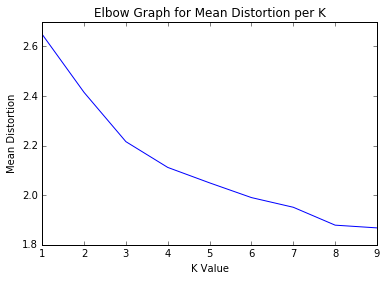

In [9]:
find_k(np.matrix(X), range(1,10),1)

From above, it appears that either 3 or 4 would be a good number of clusters.   Lets go with 4 to start.   

Why 4?  Well, I have domain experience that tells me there are 5 scotch 'regions' in scotland, and my guess is that each would have a unique taste.   But, the data doesn't support 5, it's past the elbow. So, given two 'elbows' in this graph, I'll pick the one that conforms more closely to my prior beliefs first (although you should try both).     

In [10]:
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_model.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=42, tol=0.0001,
    verbose=0)

In [11]:
df['labels'] = kmeans_model.labels_

In [12]:
df.head(10)

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude,labels
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,PH15 2EB,286580,749680,0
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,AB38 9PJ,326340,842570,0
2,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,AB5 5LI,352960,839320,1
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,PA42 7EB,141560,646220,2
4,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,AB54 4NH,355350,829140,3
5,ArranIsleOf,2,3,1,1,0,1,1,1,0,1,1,2,KA27 8HJ,194050,649950,1
6,Auchentoshan,0,2,0,0,0,1,1,0,2,2,3,3,G81 4SJ,247670,672610,1
7,Auchroisk,2,3,1,0,0,2,1,2,2,2,2,1,AB55 3XS,340754,848623,0
8,Aultmore,2,2,1,0,0,1,0,0,2,2,2,2,AB55 3QY,340754,848623,1
9,Balblair,2,3,2,1,0,0,2,0,2,1,2,1,IV19 1LB,270820,885770,1


In [13]:
df[df['labels'] == 2]

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude,labels
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,PA42 7EB,141560,646220,2
21,Caol Ila,3,1,4,2,1,0,2,0,2,1,1,1,PA46 7RL,142920,670040,2
23,Clynelish,3,2,3,3,1,0,2,0,1,1,2,0,KW9 6LB,290250,904230,2
57,Lagavulin,4,1,4,4,1,0,1,2,1,1,1,0,PA42 7DZ,140430,645730,2
58,Laphroig,4,2,4,4,1,0,0,1,1,1,0,0,PA42 7DU,138680,645160,2
77,Talisker,4,2,3,3,0,1,3,0,1,2,2,0,IV47 8SR,137950,831770,2


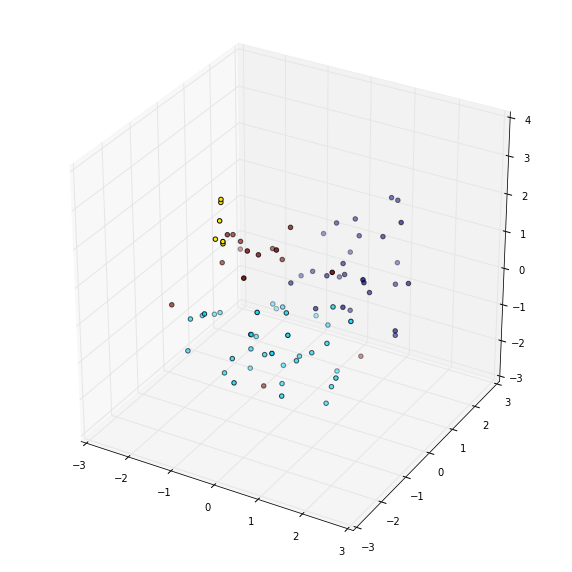

In [14]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

model = TSNE(n_components=3, learning_rate=12, random_state=10)
X_tsne = model.fit_transform(X) 
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:,2], c=kmeans_model.labels_)